In [32]:
# Import the pandas library and alias it as 'pd' for convenience
import pandas as pd


In [33]:
# Define the variable 'british_air_review' and read the CSV file into a pandas DataFrame
# Assumes the CSV file is located at "/content/British_Airway_Review.csv"
british_air_review = pd.read_csv("/content/British_Airway_Review.csv")

# The variable 'british_air_review' now holds the DataFrame containing the data from the CSV file

In [34]:
print(british_air_review.head())

                                             reviews             date  \
0  ✅ Trip Verified |  I had the most fantastic BA...  1st August 2023   
1  ✅ Trip Verified |  Couldn’t book in online. Ar...   31st July 2023   
2  ✅ Trip Verified | London Heathrow to Mumbai in...   31st July 2023   
3  ✅ Trip Verified | Keflavík, Iceland to London ...   31st July 2023   
4  ✅ Trip Verified | Terrible Experience with Bri...   29th July 2023   

          country       seat_type recommended  stars                  route  \
0       Hong Kong  Business Class         yes      5  Heathrow to Las Vegas   
1  United Kingdom   Economy Class          no      3       Rome to Heathrow   
2         Iceland  Business Class         yes      3      Gatwick to Venice   
3         Iceland  Business Class         yes      5       London to Luanda   
4          Canada   Economy Class          no      5     Denver to Heathrow   

  type_of_traveller  
0    Family Leisure  
1      Solo Leisure  
2      Solo Leisure 

In [35]:
# Split the 'reviews' column into two separate columns using '|' as the separator to get the actual passenger review
clean_split = british_air_review['reviews'].str.split('|', expand=True, n=1)
clean_split.columns = ['verify_1', 'review_1']

# Create a new column 'passenger_review' by trimming whitespace and handling missing values
clean_split['passenger_review'] = clean_split.apply(lambda row: row['verify_1'].strip() if pd.isna(row['review_1']) else row['review_1'].strip(), axis=1)


In [36]:
# Print the first few rows of the 'clean_split' DataFrame to inspect the results
print(clean_split.head())


           verify_1                                           review_1  \
0  ✅ Trip Verified     I had the most fantastic BA Flight today. Th...   
1  ✅ Trip Verified     Couldn’t book in online. Arrived at check in...   
2  ✅ Trip Verified    London Heathrow to Mumbai in a Boeing 787-8 i...   
3  ✅ Trip Verified    Keflavík, Iceland to London Heathrow on an A3...   
4  ✅ Trip Verified    Terrible Experience with British Airways. I b...   

                                    passenger_review  
0  I had the most fantastic BA Flight today. The ...  
1  Couldn’t book in online. Arrived at check in t...  
2  London Heathrow to Mumbai in a Boeing 787-8 in...  
3  Keflavík, Iceland to London Heathrow on an A32...  
4  Terrible Experience with British Airways. I bo...  


In [37]:
# Create a new DataFrame 'british_review' containing only the 'passenger_review' column
british_review = clean_split[['passenger_review']]

# Display the first few rows of the 'british_review' DataFrame
british_review.head()


,passenger_review
0,I had the most fantastic BA Flight today. The ...
1,Couldn’t book in online. Arrived at check in t...
2,London Heathrow to Mumbai in a Boeing 787-8 in...
3,"Keflavík, Iceland to London Heathrow on an A32..."
4,Terrible Experience with British Airways. I bo...


In [38]:
# Import necessary libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')  # Add this line

# Assuming 'british_review' is your DataFrame and 'words' is your list of words
# If 'words' is a DataFrame, you can extract it as a list using words['column_name'].tolist()

# Add an 'id' column
british_review['id'] = range(1, len(british_review) + 1)

# Select relevant columns
d = british_review[['id', 'passenger_review']]

# Tokenization and sentiment analysis
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

# Tokenize and perform sentiment analysis
a = d.assign(
    word=d['passenger_review'].apply(word_tokenize)
).explode('word').query('word not in @stop_words').assign(
    sentiment=lambda x: x['word'].apply(lambda word: sia.polarity_scores(word)['compound'])
)

# Group by 'id' and count sentiments
s = a.groupby('id')['sentiment'].apply(lambda x: pd.Series([(x > 0).sum(), (x < 0).sum(), (x == 0).sum()], index=['positive', 'negative', 'neutral'])).unstack(fill_value=0)

# Calculate polarity
s['polarity'] = s['positive'] - s['negative']

# Categorize sentiment
c = s.assign(
    sentiment=s['polarity'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
)

# Display the resulting DataFrame
print(c)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-38-e23d53d66c8f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  british_review['id'] = range(1, len(british_review) + 1)


      positive  negative  neutral  polarity sentiment
id                                                   
1           17         0      108        17  positive
2            4         3       42         1  positive
3            8         2       79         6  positive
4            3         2       82         1  positive
5           13        11      382         2  positive
...        ...       ...      ...       ...       ...
2496         9         5      162         4  positive
2497         1         2      124        -1  negative
2498         4         1       35         3  positive
2499         8         2       88         6  positive
2500         3         9      114        -6  negative

[2500 rows x 5 columns]


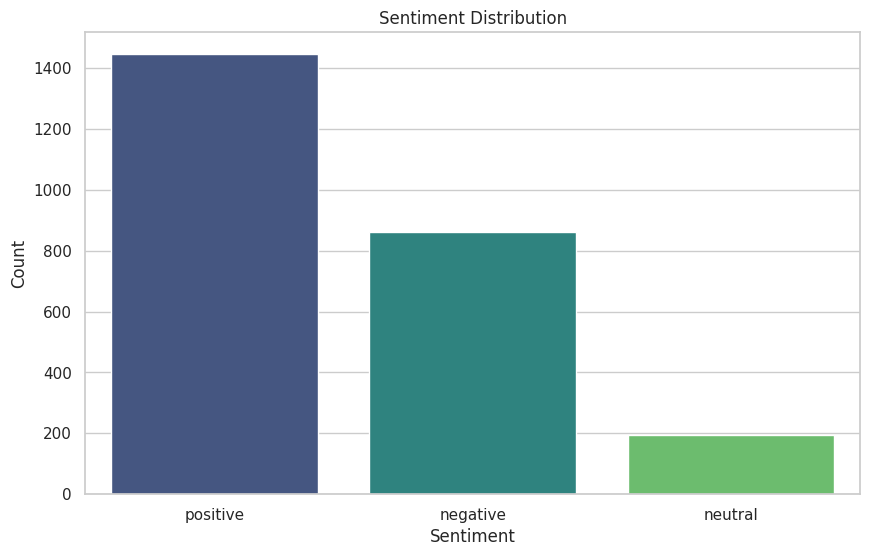

In [39]:
# Import necessary visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'c' is your sentiment DataFrame
# Bar plot for sentiment distribution
sns.set(style="whitegrid")

# Set the figure size for the plot
plt.figure(figsize=(10, 6))

# Count the occurrences of each sentiment category
sentiment_counts = c['sentiment'].value_counts()

# Create a bar plot using seaborn
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Set plot title and labels
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Display the plot
plt.show()


<ipython-input-40-254e9b4ce1b2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  british_review['passenger_review'] = british_review['passenger_review'].apply(


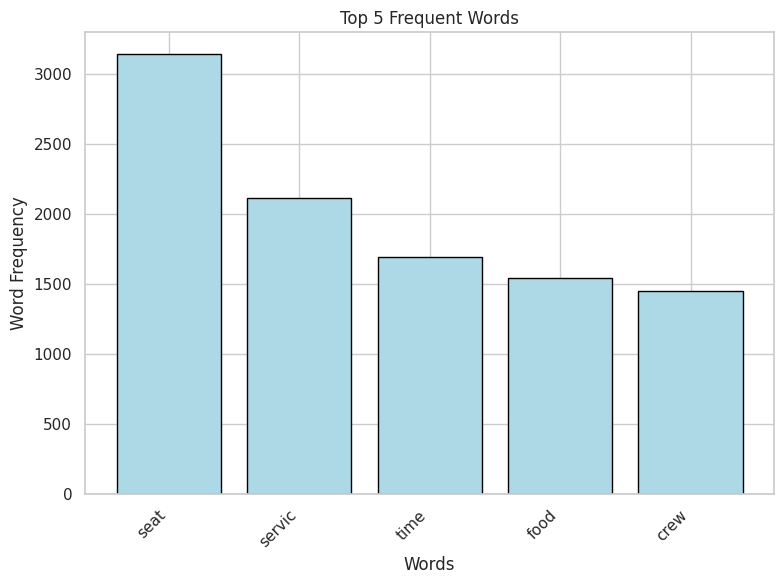

In [40]:
# Import necessary libraries
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# creating a custom stopwords list
custom_stops = set(["flights", "flight", "BA", "ba", "Airways",
                    "Airlines", "Airway", "Airline", "airlines",
                    "airway", "airways", "airline", "Flights",
                    "Flight", "british", "British", "fly", "flies", "london", "London"] +
                   stopwords.words("english"))

# Tokenization and stemming
stemmer = PorterStemmer()
british_review['passenger_review'] = british_review['passenger_review'].apply(
    lambda text: ' '.join([stemmer.stem(word.lower()) for word in word_tokenize(text) if word.lower() not in custom_stops])
)

# Term Frequency Analysis
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(british_review['passenger_review'])
terms = vectorizer.get_feature_names_out()
term_frequencies = X.sum(axis=0).A1

# Create a DataFrame for word frequencies
df_word_frequencies = pd.DataFrame({'word': terms, 'freq': term_frequencies})

# Select top 5 frequent words
df_top_words = df_word_frequencies.nlargest(5, 'freq')

# Create a Bar Chart
plt.figure(figsize=(8, 6))
plt.bar(df_top_words['word'], df_top_words['freq'], color='lightblue', edgecolor='black')
plt.xlabel('Words')
plt.ylabel('Word Frequency')
plt.title('Top 5 Frequent Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


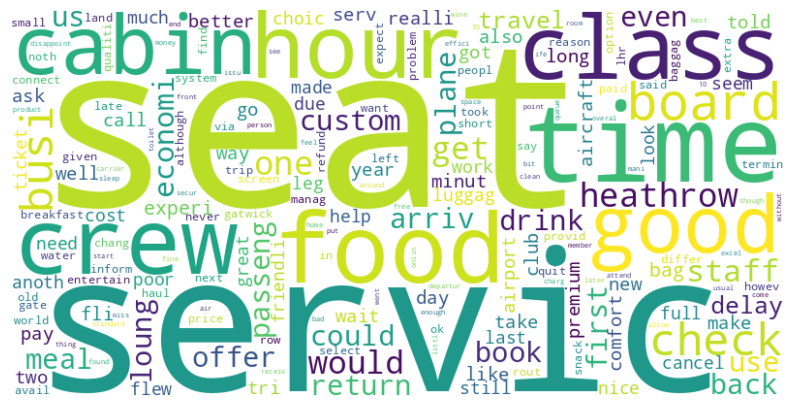

In [41]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'df_word_frequencies' is your DataFrame with word frequencies
# Assuming 'word' and 'freq' are the column names for words and frequencies, respectively

# Select top 200 words
k = df_word_frequencies.nlargest(200, 'freq')

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(dict(zip(k['word'], k['freq'])))

# Display the WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



**1. Data Acquisition**
This dataset contains customer reviews of British Airways, a prominent airline operating in the United Kingdom. The reviews encompass a wide range of experiences and opinions expressed by travelers who have flown with British Airways. The dataset was gotten from kaggle [go to dataset](https://www.kaggle.com/datasets/roshansalunke/british-airways-customer-reviews)

**2. Reading and Preprocessing Data:**

The code begins by importing necessary libraries and reading a CSV file named "British_Airway_Review.csv" into a Pandas DataFrame called british_clean.
It then splits the 'reviews' column into two separate columns using '|' as the separator, creating a new column 'passenger_review' by handling whitespace and missing values.

**3. Sentiment Analysis:**

The script uses the Natural Language Toolkit (NLTK) library for sentiment analysis. It tokenizes the 'passenger_review' column, removes stopwords, and calculates sentiment scores using the VADER sentiment analyzer.
The sentiment scores are then aggregated and categorized into positive, negative, neutral sentiments, and overall polarity.

**4. Visualization of Sentiment Distribution:**

Matplotlib and Seaborn are used to create a bar plot visualizing the distribution of sentiments (positive, negative, neutral) in the dataset.

**5. Text Preprocessing for Word Frequency Analysis:**

The code applies additional text preprocessing, including stemming and removing custom stopwords, using the NLTK Porter Stemmer.
It then performs term frequency analysis using scikit-learn's CountVectorizer to create a DataFrame (df_word_frequencies) with word frequencies.

**6. Visualization of Top 5 Frequent Words:**

The code selects the top 5 frequent words and creates a bar chart to visualize their frequencies.

**7. Word Cloud Visualization:**
The script uses the WordCloud library to generate and display a word cloud based on word frequencies, providing a visual representation of the most common words in the reviews.